In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 11.6 MB/s 
     |████████████████████████████████| 6.6 MB 68.0 MB/s 
     |████████████████████████████████| 101 kB 10.3 MB/s 


In [ ]:
import pandas as pd, glob, re, string,seaborn as sns, random, numpy as np, os, transformers, torch, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support,roc_auc_score, classification_report, auc, roc_curve,f1_score
from tqdm import tqdm
# specify GPU
device = torch.device("cuda")
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification ,BertTokenizer, AutoModel, AutoTokenizer,Trainer, TrainingArguments,AutoModelForPreTraining,AutoModelForSequenceClassification

In [ ]:
def create_dataframe(path):
    train_files = glob.glob(path + "/*.csv")
    df = pd.concat([pd.read_csv(filename, index_col=None, header=0) for filename in train_files], axis=0, ignore_index=True)
    df = df.drop(['Unnamed: 0'],axis=1)
    return df
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf
        tf.random.set_seed(seed)
class LegalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)
def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    outputs = model1(**inputs)
    probs = outputs[0].softmax(1)
    return target_names[probs.argmax()], probs.argmax().cpu().numpy()
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = f1_score(labels, preds,average='weighted')
  precision, recall, fscore, support = precision_recall_fscore_support(labels, preds, average='weighted')
  return {
      'Accuracy' : round(accuracy_score(labels, preds),8),'Precision' : round(precision,8),
        'Recall' : round(recall,8), 'F-Score' : round(fscore,8), 
        'AUC ROC' : round(multiclass_roc_auc_score(labels, np.array(preds), average="macro"),8)
  }
path = r'/content/drive/My Drive/LegalArguementMining/'
df_train = create_dataframe(path + "Train_data")
df_train,df_untouched = train_test_split(df_train, stratify=df_train['Target'], test_size=0.2)
df_test = create_dataframe(path + "test_data")
df_unlabelled = create_dataframe(path + "Unlabeled_data")
df_unlabelled_new = pd.read_csv(path + "Unlabelled_new/df_unlabelled_new.csv")
df_test_new = pd.read_csv(r'/content/drive/My Drive/LegalArguementMining/test/test_bert2.csv',encoding='latin-1')
l = LabelEncoder().fit(df_train['Target'])
df_train['Target'] = l.transform(df_train['Target'])
df_untouched['Target'] = l.transform(df_untouched['Target'])
df_test['Target'] = l.transform(df_test['Target'])

print(df_train.shape)
print(df_untouched.shape)
print(df_unlabelled_new.shape)
df_train = pd.concat([df_train,df_untouched,df_test_new],axis=0)
print(df_train.shape)

train_texts , train_labels = df_train['Sentence'], df_train['Target']
valid_texts, valid_labels = df_test['Sentence'], df_test['Target']
test_texts, test_labels = df_untouched['Sentence'], df_untouched['Target']
target_names = df_train['Target'].value_counts().keys().tolist()

set_seed(1)
max_length = 512
model_name = "nlpaueb/legal-bert-small-uncased"
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts.to_list(), truncation=True, padding=True, max_length=max_length)

# convert our tokenized data into a torch Dataset
train_dataset = LegalDataset(train_encodings, train_labels.to_list())
valid_dataset = LegalDataset(valid_encodings, valid_labels.to_list())

(30168, 2)
(7543, 2)
(502560, 2)
(37897, 2)


Some weights of the model checkpoint at nlpaueb/legal-bert-small-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [ ]:
training_args = TrainingArguments(
    output_dir='./legal_results_small',          # output directory
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./legal_logs_small',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=400,               # log & save weights each logging_steps
    save_steps=400,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
# train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 37897
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18952


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F-score,Auc roc
400,1.245700,0.963468,0.675624,0.646701,0.675624,0.649950,0.700962
800,0.768000,0.905797,0.689060,0.689351,0.689060,0.676804,0.736909
1200,0.631600,0.841911,0.731286,0.721553,0.731286,0.718348,0.762050
1600,0.508700,0.939062,0.725528,0.726231,0.725528,0.721230,0.771838
2000,0.442800,1.176891,0.731286,0.727945,0.731286,0.728547,0.775491
2400,0.360600,1.207191,0.721689,0.729497,0.721689,0.722977,0.778635
2800,0.330100,1.333166,0.710173,0.712762,0.710173,0.709671,0.777564
3200,0.293300,1.402647,0.727447,0.735254,0.727447,0.728290,0.783067
3600,0.293700,1.339413,0.738964,0.748712,0.738964,0.735178,0.788152
4000,0.227300,1.419744,0.738964,0.735423,0.738964,0.731021,0.787458


***** Running Evaluation *****
  Num examples = 521
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./legal_results_small/checkpoint-400
Configuration saved in ./legal_results_small/checkpoint-400/config.json
Model weights saved in ./legal_results_small/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 521
  Batch size = 20
Saving model checkpoint to ./legal_results_small/checkpoint-800
Configuration saved in ./legal_results_small/checkpoint-800/config.json
Model weights saved in ./legal_results_small/checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 521
  Batch size = 20
Saving model checkpoint to ./legal_results_small/ch

TrainOutput(global_step=18952, training_loss=0.1670809469931535, metrics={'train_runtime': 1712.9061, 'train_samples_per_second': 88.498, 'train_steps_per_second': 11.064, 'total_flos': 5478100377632400.0, 'train_loss': 0.1670809469931535, 'epoch': 4.0})

In [ ]:
trainer._load_from_checkpoint("/content/legal_results_small/checkpoint-17200")

Loading model from /content/legal_results_small/checkpoint-17200.


In [ ]:
# evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 521
  Batch size = 20


{'eval_loss': 1.5811454057693481,
 'eval_Accuracy': 0.79462572,
 'eval_Precision': 0.80052747,
 'eval_Recall': 0.79462572,
 'eval_F-Score': 0.79232865,
 'eval_AUC ROC': 0.82903456,
 'eval_runtime': 0.6774,
 'eval_samples_per_second': 769.107,
 'eval_steps_per_second': 39.858,
 'epoch': 4.0}

In [ ]:
model1 = BertForSequenceClassification.from_pretrained("/content/legal_results_small/checkpoint-17200", num_labels=len(target_names)).to("cuda")
pred = [get_prediction(i)[1] for i in df_test.Sentence.values.tolist()]
print('Accuracy of Test Dataset :',accuracy_score(pred, df_test.Target.values.tolist()))

loading configuration file /content/legal_results_small/checkpoint-17200/config.json
Model config BertConfig {
  "_name_or_path": "nlpaueb/legal-bert-small-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolut

Accuracy of Test Dataset : 0.7946257197696737


[[ 58   2  15   0   1   1   0]
 [  2  24   0   0   0   0   0]
 [ 18   4 231   7   5   1   1]
 [  4   0   7  53   0   0   1]
 [  2   0   5   2  21   0   4]
 [  6   1   6   0   0   5   0]
 [  9   0   1   1   0   1  22]]
Accuracy =  0.79462572 
Precision =  0.80052747 
Recall =  0.79462572 
F-Score =  0.79232865 
AUC ROC =  0.82903456
              precision    recall  f1-score   support

           0       0.59      0.75      0.66        77
           1       0.77      0.92      0.84        26
           2       0.87      0.87      0.87       267
           3       0.84      0.82      0.83        65
           4       0.78      0.62      0.69        34
           5       0.62      0.28      0.38        18
           6       0.79      0.65      0.71        34

    accuracy                           0.79       521
   macro avg       0.75      0.70      0.71       521
weighted avg       0.80      0.79      0.79       521



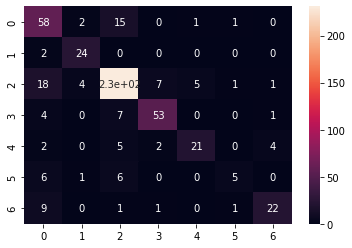

In [ ]:
def confusion_matrixs(y, yp):
  k = sorted(list(set(y)))
  df = pd.DataFrame(index=k, columns=k)
  df.fillna(0, inplace=True)
  for i, j in zip(y, yp):
    df.loc[i, j] += 1
  sns.heatmap(df, annot=True)
  plt.plot()
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)
print(confusion_matrix(df_test.Target.values.tolist(), pred))
precision, recall, fscore, support = precision_recall_fscore_support(df_test.Target.values.tolist(), pred, average='weighted')
print('Accuracy = ',round(accuracy_score(pred, df_test.Target.values.tolist()),8),'\nPrecision = ',round(precision,8),
      '\nRecall = ', round(recall,8), '\nF-Score = ',round(fscore,8), 
      '\nAUC ROC = ', round(multiclass_roc_auc_score(df_test.Target.values.tolist(),np.array(pred), average="macro"),8))
confusion_matrixs(df_test.Target.values.tolist(),np.array(pred))
print(classification_report(df_test.Target.values.tolist(),np.array(pred)))